<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_GPU_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarck GPU processing 

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, symbolSync, pnorm, signal_power
from optic.models.devices import pdmCoherentReceiver, basicLaserModel

from optic.models.modelsGPU import manakovSSF as manakovSSF_GPU

from optic.models.channels import manakovSSF as manakovSSF_CPU

from optic.models.tx import simpleWDMTx
from optic.utils import parameters, dBm2W
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.dsp.carrierRecovery import cpr
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM
from optic.plot import pconst, plotPSD

import scipy.constants as const

import logging as logg
logg.basicConfig(level=logg.WARN, format='%(message)s', force=True)

import time
from tqdm.notebook import tqdm

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

## Summary

OptiCommPy is a Python package for simulating optical communication systems, including Wavelength Division Multiplexing (WDM) systems. This notebook shows an example of how to use OptiCommPy to run a simulation of a coherent WDM system with several modulated co-propagating optical carriers.


## Transmitter

The initial step involves defining a comprehensive set of parameters for the WDM transmitters. The table below outlines a specific WDM system configuration where $11\times32$GBd PDM-16QAM carriers are generated, following a frequency grid of 37.5 GHz that is centered precisely at the optical frequency of 193.1 THz. Each carrier is modulated with a Nyquist spectrum, by means of a root-raised-cosine (RRC) pulse-shaping filter with a rolloff factor of 0.01. The continuous-wave (CW) lasers utilized in this setup are characterized by linewidths of 100 kHz, with each modulated carrier boasting an output power of -2 dBm. 

| Parameter    | Description                                    | Value        |
|--------------|------------------------------------------------|--------------|
| M            | Order of the modulation format                 | 16           |
| Rs           | Symbol rate [baud]                             | 32e9         |
| SpS          | Samples per symbol                             | 16           |
| pulse        | Pulse shaping filter                           | 'rrc'        |
| Ntaps        | Number of pulse shaping filter coefficients    | 4096         |
| alphaRRC     | RRC rolloff                                    | 0.01         |
| Pch_dBm      | Power per WDM channel [dBm]                    | -2           |
| Nch          | Number of WDM channels                         | 11           |
| Fc           | Central frequency of the WDM spectrum [Hz]     | 193.1e12     |
| lw           | Laser linewidth [Hz]                           | 100e3        |
| freqSpac     | WDM grid spacing [Hz]                          | 37.5e9       |
| Nmodes       | Number of polarization modes                   | 2            |
| Nbits        | Total number of bits per polarization          | 400000       |

The number of samples per symbol (SpS) adopted in the simulation is set to 16, meaning that the signals are represented at a corresponding sampling rate (Fs) of Fs = 16$\times$Rs = 512 GSa/s, where Rs is the symbol rate (i.e. 32GBd). The total bandwidth simulated in this setup is 11$\times$37.5 GHz = 412.5 GHz, which is below Fs, thus avoiding aliasing in the extremes of the spectrum. The total simulated interval corresponds to 100000 signaling periods, corresponding to 400000 bits transmitted per polarization per WDM carrier.


**Polarization multiplexed WDM signal generation**

In [6]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 4           # samples per symbol
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 4096     # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = -2        # power per WDM channel [dBm]
paramTx.Nch     = 1       # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.lw      = 100e3    # laser linewidth in Hz
paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]
paramTx.prgsBar = False   # show progress bar

In [7]:
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 500     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.prgsBar = False   # show progress bar
#paramCh.saveSpanN = [1, 5, 9, 14]
paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate

In [8]:
numberOfSymbols = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
timeCPU = np.zeros(len(numberOfSymbols))
timeGPU = np.zeros(len(numberOfSymbols))

paramTx.Pch_dBm = -2 # power per WDM channel [dBm]

for idx, Nsymb in enumerate(tqdm(numberOfSymbols)):    
    paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization
    # generate WDM signal
    sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_CPU(sigWDM_Tx, paramCh)
    end = time.time()    
    timeCPU[idx] = end - start

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_GPU(sigWDM_Tx, paramCh)
    end = time.time()    
    timeGPU[idx] = end - start

  0%|          | 0/7 [00:00<?, ?it/s]

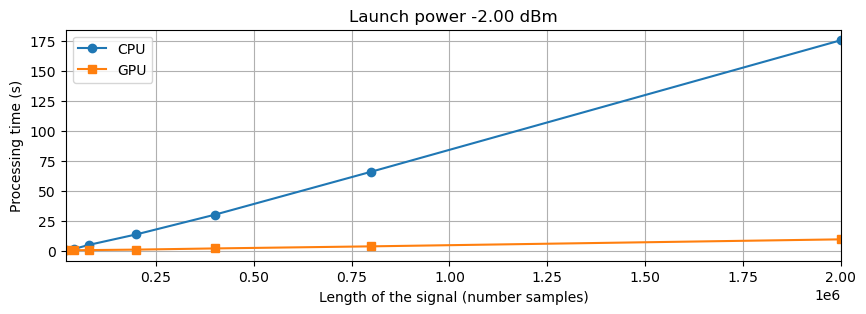

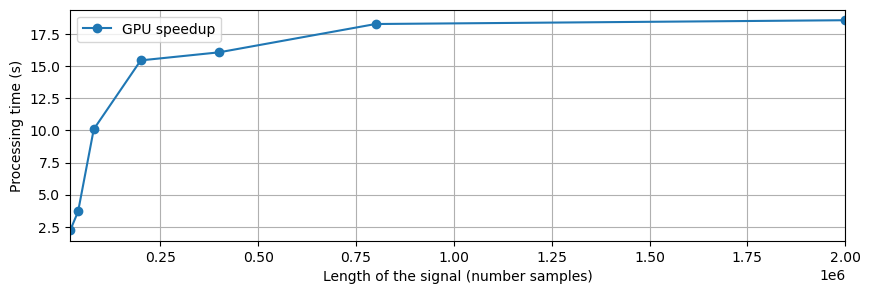

In [9]:
signalLength = numberOfSymbols*paramTx.SpS


plt.plot(signalLength, timeCPU,'-o', label='CPU')
plt.plot(signalLength, timeGPU,'-s', label='GPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.title(f'Launch power {paramTx.Pch_dBm:.2f} dBm')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength))


plt.figure()
plt.plot(signalLength, timeCPU/timeGPU,'-o', label='GPU speedup')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('GPU speedup ($\times$)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));

In [ ]:
numberOfSymbols = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5])
timeCPU = np.zeros(len(numberOfSymbols))
timeGPU = np.zeros(len(numberOfSymbols))

paramTx.Pch_dBm = 4 # power per WDM channel [dBm]

for idx, Nsymb in enumerate(tqdm(numberOfSymbols)):    
    paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization
    # generate WDM signal
    sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_CPU(sigWDM_Tx, paramCh)
    end = time.time()    
    timeCPU[idx] = end - start

    # nonlinear signal propagation
    start = time.time()
    sigWDM = manakovSSF_GPU(sigWDM_Tx, paramCh)
    end = time.time()    
    timeGPU[idx] = end - start

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
signalLength = numberOfSymbols*paramTx.SpS

plt.plot(signalLength, timeCPU,'-o', label='CPU')
plt.plot(signalLength, timeGPU,'-s', label='GPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.title(f'Launch power {paramTx.Pch_dBm:.2f} dBm')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength))


plt.figure()
plt.plot(signalLength, timeCPU/timeGPU,'-o', label='GPU speedup')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('GPU speedup ($\times$)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));